In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [14]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [5]:



# Load dataset
data = pd.read_csv('Input_data/cpa_preprocessed.csv')

# Drop target variable
features = data.drop(columns=['NumStorePurchases'])



In [6]:

# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Split into training and test sets
X_train, X_test = train_test_split(normalized_features, test_size=0.2, random_state=42)


In [ ]:

# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=30, n_init=10)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))


C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_

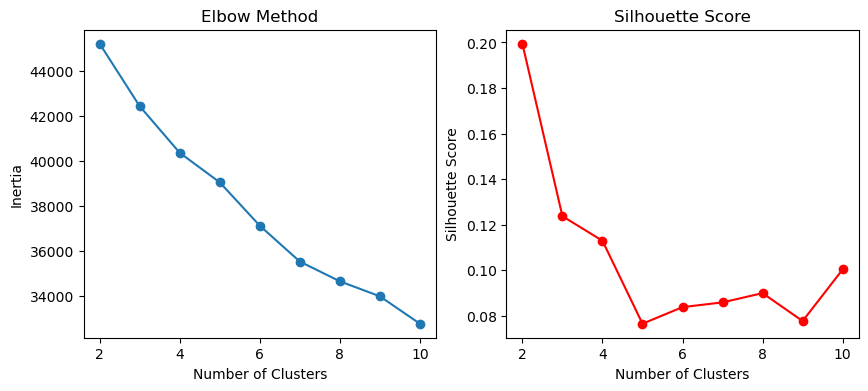

In [ ]:

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.subplot_title = 'Silhouette Score'
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()


In [9]:


# Optimal number of clusters (choosing the best from both methods)
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_train)

# Apply Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_train)


Optimal number of clusters: 2


C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\ivann\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [10]:


# Evaluate clustering performance
kmeans_silhouette = silhouette_score(X_train, kmeans_labels)
kmeans_db = davies_bouldin_score(X_train, kmeans_labels)

gmm_silhouette = silhouette_score(X_train, gmm_labels)
gmm_db = davies_bouldin_score(X_train, gmm_labels)
gmm_log_likelihood = gmm.score(X_train)

print(f'KMeans - Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db}')
print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_db}, Log-Likelihood: {gmm_log_likelihood}')



KMeans - Silhouette Score: 0.19944687450088575, Davies-Bouldin Index: 2.1576420593700316
GMM - Silhouette Score: 0.2650088076060738, Davies-Bouldin Index: 2.541227385201248, Log-Likelihood: -10.006633864422957


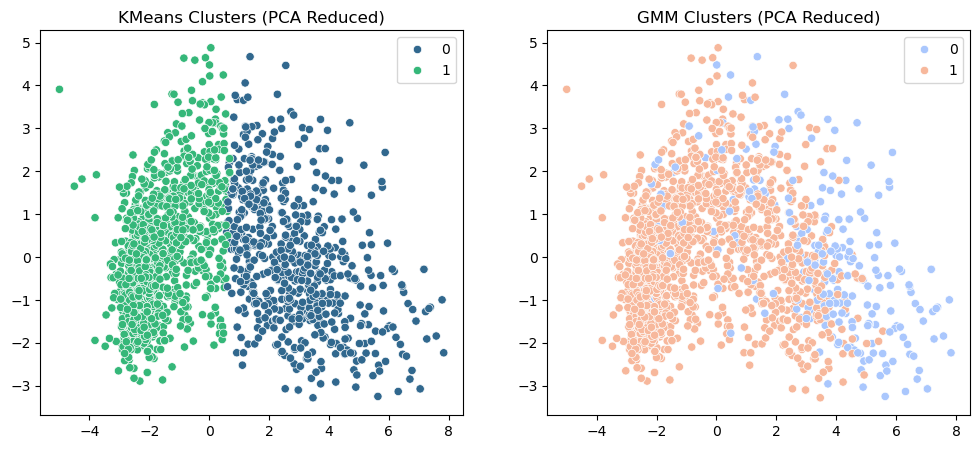

In [11]:

# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('KMeans Clusters (PCA Reduced)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='coolwarm')
plt.title('GMM Clusters (PCA Reduced)')
plt.show()


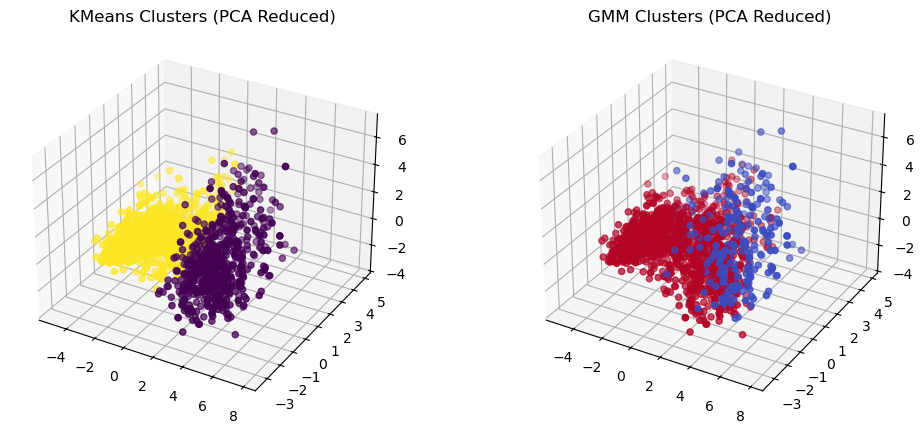

In [12]:

# Visualize clusters using PCA (3D)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=kmeans_labels, cmap='viridis')
ax.set_title('KMeans Clusters (PCA Reduced)')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=gmm_labels, cmap='coolwarm')
ax.set_title('GMM Clusters (PCA Reduced)')

plt.show()
